## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from typing_extensions import Literal

from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score



import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED) # PyTorch
torch.cuda.manual_seed(SEED) # PyTorch Cuda part


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

# Data loading

We will use [Kaggle Data](https://www.kaggle.com/abhinand05/magic-gamma-telescope-dataset) and try to fake some data on photons and hadrons with Conditional WGAN and CVAE.

0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [2]:
# Read Data
names = np.array(['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans', 'Alpha', 'Dist', 'class'])
data = pd.read_csv('Data/telescope_data.csv', index_col=0)
data.columns = names
data.head()

,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Setting goal

As already mentioned we are to use WGAN and CVAE to generate parameters of clusters for both photons and hadrons. Further on:

- $X$ - real objects matrix we need to learn how to generate;
- $y$ - real targets we will use as a condition while generating.

In [3]:
# Clusters' parameters
X = data[names[:-1]].values
X = np.abs(X)

# Setting class labels
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == 'h'] = 0

# Data Visualisation

In [4]:
def plot_hists(X1, X2, names, label1, label2, bins):
    plt.figure(figsize=(4 * 4, 4 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.hist(X1[:, i], bins=bins, alpha=0.5, label=label1)
        plt.hist(X2[:, i], bins=bins, alpha=0.5, label=label2)
        plt.xlabel(names[i], size=14)
        plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

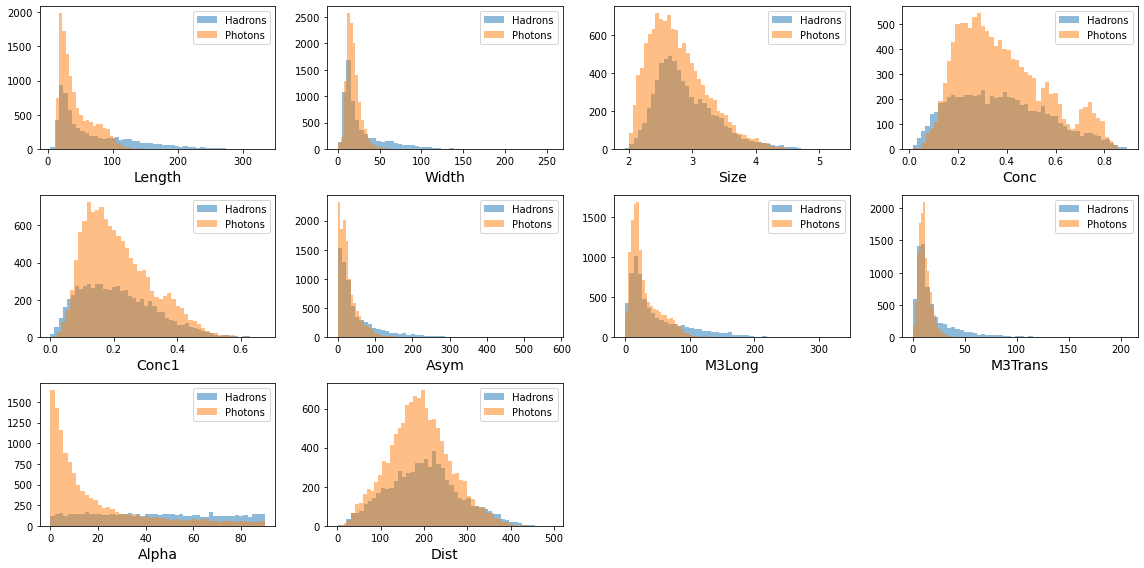

In [5]:
plot_hists(X[y[:, 0]==0], X[y[:, 0]==1], names=names, label1="Hadrons", label2="Photons", bins=50)

# Data preprocessing 

We can see most of the features have some heavy tails meaning it would be difficult to train GANs. So we will transform them to make their distribution normal.

In [6]:
qt = QuantileTransformer(output_distribution='normal')
X_qt = qt.fit_transform(X)

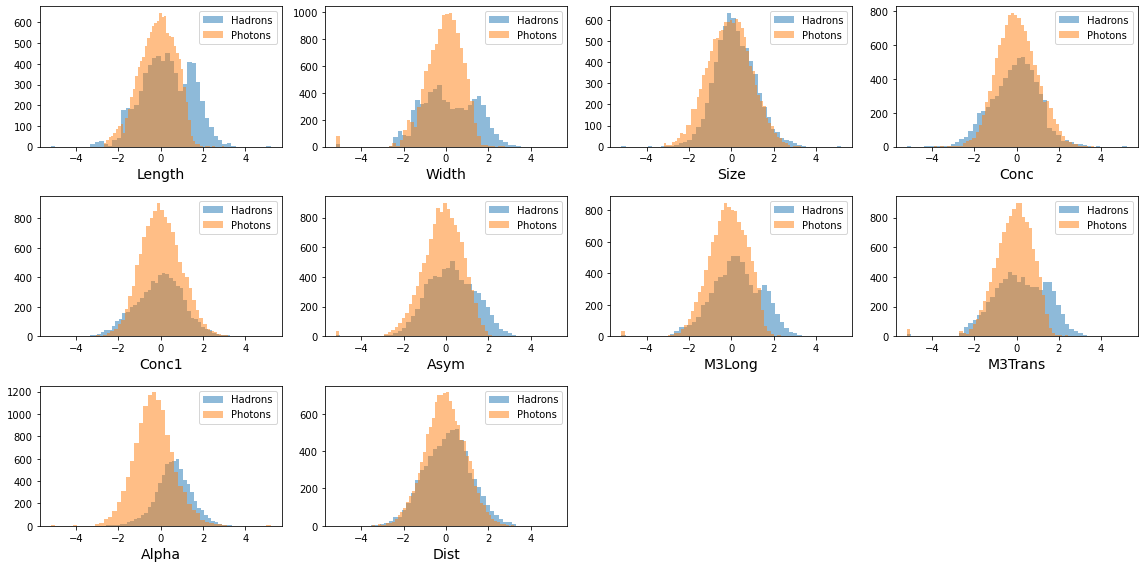

In [7]:
plot_hists(X_qt[y[:, 0]==0], X_qt[y[:, 0]==1], names=names, label1="Hadrons", label2="Photons", bins=50)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_qt, y, stratify=y, test_size=0.5, shuffle=True) # Train and test split.

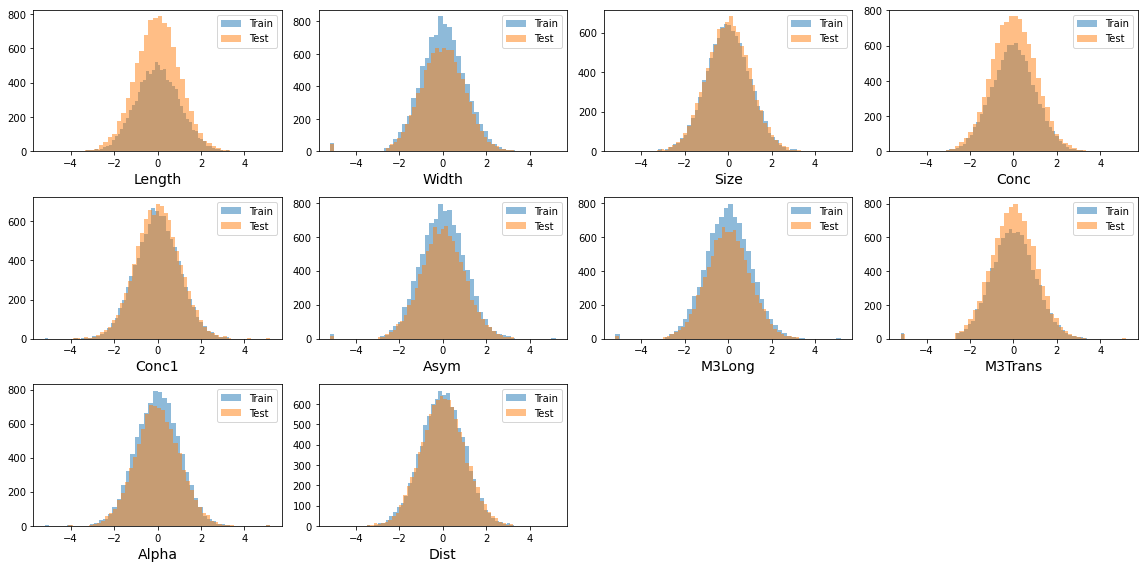

In [9]:
plot_hists(X_train, X_test, names=names, label1="Train", label2="Test", bins=50)

# Conditional WGAN

We will use this loss function for WGAN training:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + \frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

Here $z_i$ is some noise vector, $x_i$ is some real features vector, $y_i$ is some real target (**0** for hadron and **1** for photon), $G(z, y)$ is the generator providing us with fake features vector $\hat{x}$, $D(x, y)$ us the discriminator returning us some number stating its confidence in $x$'s plausibility.


In [10]:
def wgan_loss(real_objects_scores: torch.Tensor,
             generated_objects_scores: torch.Tensor, 
             by : Literal['generator', 'discriminator'] = 'generator') -> torch.Tensor:
    '''
    Both generator and discriminator WGAN loss implementation
    '''
    if by=='generator':
        # Generator loss
        return -torch.mean(generated_objects_scores)
    elif by == 'discriminator':
        # Discriminator loss
        return -torch.mean(real_objects_scores) + torch.mean(generated_objects_scores)

## Generator

We will use the following architecture for the generator:

- Fully Connected layer with 100 neurons;
- Batch Norm layer;
- ReLU activation;
- Fully Connected layer with 100 neurons;
- Batch Norm layer;
- ReLU activation;
- Output layer.

In [11]:
class Generator(nn.Module):
    
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, int(100)),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(int(100), int(100)),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, n_outputs)
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Discriminator

We will use the following architecture for the discriminator:

- Fully Connected layer with 100 neurons;
- ReLU activation;
- Fully Connected layer with 100 neurons;
- ReLU activation;
- Output layer.

In [12]:
class Discriminator(nn.Module):
    
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(int(n_inputs), int(100)),
            nn.ReLU(True),
            nn.Linear(int(100), int(100)),
            nn.ReLU(True),
            nn.Linear(int(100), 1)
        )

    def forward(self, x, y):
        for p in self.parameters():
            p.data.clamp_(-0.01, 0.01)
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

## WGAN training class

- We will use RMSProp as optimizer.
- We will make it possible to make several discriminator training steps per one generator steps.

In [13]:
class Fitter(object):
    
    def __init__(self, generator, discriminator, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, n_critic=5):
        
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        
        self.opt_gen  = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)
        
        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)
    
    
    def fit(self, X, y):
        
        # We start with Numpy
        # Numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        
        # Tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)
        
        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)
        
        # Save some loss history to plot later
        self.loss_history = []

        # Fit GAN
        for epoch in tqdm(range(self.n_epochs)):
            # Epochs iteration
            
            for i, (real_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):
                # Batch iteration
                
                n_objects = len(real_batch)
                
                # Making noise for Generator
                z = torch.normal(0, 1, (n_objects, self.latent_dim), device=DEVICE)

                gen_objects = self.generator(z, cond_batch)

                real_objects_scores, gen_objects_scores = torch.split(self.discriminator(torch.cat([real_batch, gen_objects], dim=0), 
                                                                                         torch.cat([cond_batch, cond_batch], dim=0)), 
                                                                                         n_objects)

                if (i % (self.n_critic + 1)) == 0:
                    # We might want to make less generator than discriminator steps.
                    
                    self.opt_gen.zero_grad()
                    gen_loss = wgan_loss(..., gen_objects_scores, by='generator')
                    gen_loss.backward()
                    self.opt_gen.step()
                else:
                    self.opt_disc.zero_grad()
                    discr_loss = wgan_loss(real_objects_scores, gen_objects_scores, by='discriminator')
                    discr_loss.backward()
                    self.opt_disc.step()

            # Calculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim)).to(DEVICE)
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(self.discriminator(X_fake, y_cond))
            self.loss_history.append(loss_epoch.detach().cpu())
                    
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Generating new objects function

In [14]:
def generate(generator, y, latent_dim):
    z = torch.normal(0, 1, (len(y), latent_dim), device=DEVICE)
    X_fake = generator(z, torch.tensor(y, dtype=torch.float, device=DEVICE))
    X_fake = X_fake.detach().cpu().numpy()
    return X_fake

## Training


In [15]:
latent_dim = 10
generator = Generator(n_inputs=latent_dim+y.shape[1], 
                      n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

WGAN_PARAMS = {
    'batch_size': 50,
    'n_epochs': 100,
    'latent_dim': latent_dim,
    'lr': 1e-4,
    'n_critic': 5
}

In [16]:
fitter = Fitter(generator, discriminator, **WGAN_PARAMS)
fitter.fit(X_train, y_train)

100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


## Results analysis

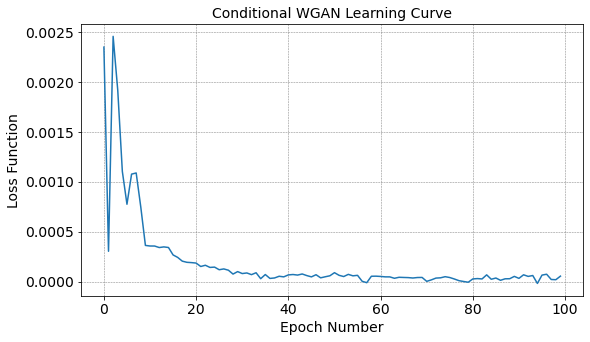

In [17]:
# Plot WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)

plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.title("Conditional WGAN Learning Curve", size=14)

plt.xticks(size=14)
plt.yticks(size=14)

plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

Let us generate some fake matrices `X_fake_train` and `X_fake_test` and compare them to real `X_train` and `X_test`

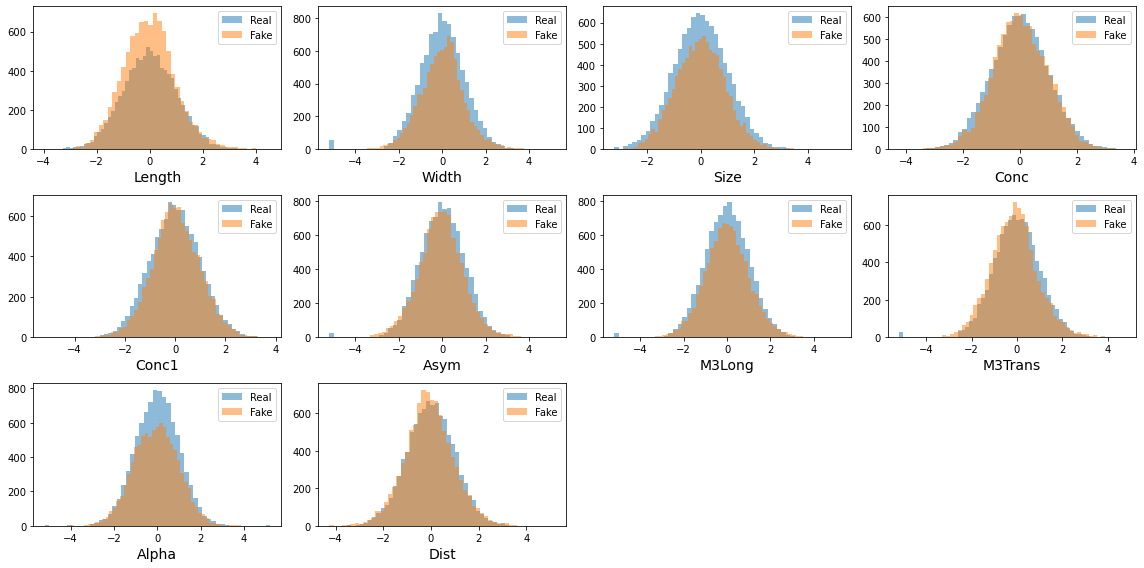

In [18]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

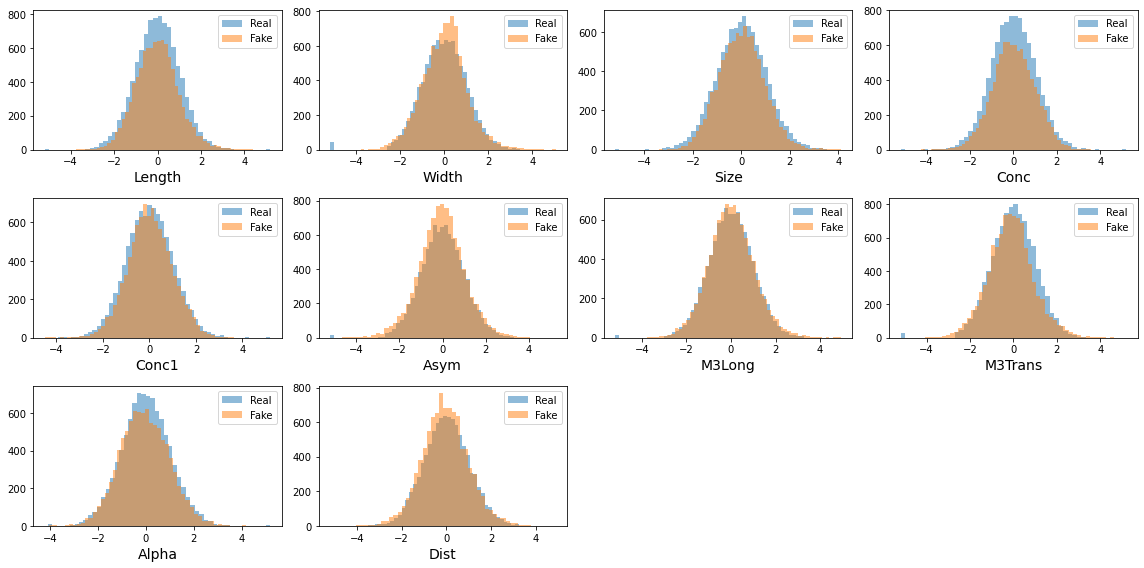

In [19]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

There is also another way to chek the generated objects are fine. We will combine both generated and real objects and see if a classifier can distinguish them from each other. We can use ROC-AUC for this one: we would like it to be close to 0.5 meaning the classifier cannot set them apart.

In [20]:
# Combine 

XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [21]:
# Train classifier
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# Get results
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [22]:
auc = roc_auc_score(yy_test, yy_test_proba)
print(f'ROC-AUC = {auc}')

ROC-AUC = 0.684583835046622


Close enough yet there is much room for improvement.

# Conditional VAE

## Encoder

We will use the following architecture for the Encoder:

- Fully Connected layer with 100 neurons;
- Batch Norm layer;
- ReLU activation;
- Fully Connected layer with 100 neurons;
- Batch Norm layer;
- ReLU activation;
- Output layer for mu; Output layer for log_sigma

In [23]:
class Encoder(nn.Module):
    def __init__(self, n_inputs, lat_size):
        super(Encoder, self).__init__()
        
        self.enc_net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU()
        )
        
        self.mu = nn.Linear(100, lat_size)
        self.log_sigma = nn.Linear(100, lat_size)
        
    def forward(self, x, y):
        z = torch.cat((x, y), dim=1)
        _z = self.enc_net(z)
        mu = self.mu(_z)
        log_sigma = self.log_sigma(_z)
        return mu, log_sigma 

## Decoder

We will use the following architecture for the decoder:

- Fully Connected layer with 100 neurons;
- ReLU activation;
- Fully Connected layer with 100 neurons;
- ReLU activation;
- Output layer.

In [24]:
class Decoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Decoder, self).__init__()
        
        self.dec_net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )
        
    def forward(self, z, y):
        z_cond = torch.cat((z, y), dim=1)
        x_rec = self.dec_net(z_cond)
        return x_rec

## CVAE Fitter

- For this one we will have loss included into class in order to make code less messy.

In [25]:
class CVAEFitter(object):
    
    def __init__(self, encoder, decoder, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, kl_weight=0.001):
        
        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.kl_weight = kl_weight
        
        self.criterion = nn.MSELoss()
        self.opt  = torch.optim.RMSprop(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=self.lr)
        
        self.encoder.to(DEVICE)
        self.decoder.to(DEVICE)
        
        
    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(DEVICE)
        return mu + torch.exp(log_sigma / 2) * eps
    
    def custom_loss(self, x, rec_x, mu, log_sigma):
        kl = torch.mean(-0.5 * torch.sum(1 + log_sigma - mu ** 2 - log_sigma.exp(), dim = 1), dim = 0)
        recon_loss = self.criterion(x, rec_x)
        return kl * self.kl_weight + recon_loss
    
    
    def compute_loss(self, x_batch, cond_batch):
        
        mu, log_sigma = self.encoder(x_batch, cond_batch)
        z = self.sample_z(mu, log_sigma)
        rec_x = self.decoder(z, cond_batch)
        loss = self.custom_loss(x_batch, rec_x, mu, log_sigma)
        
        return loss
    
    
    def fit(self, X, y):

        # We start with Numpy
        # Numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        
        # Tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)
        
        # Turn on training
        self.encoder.train(True)
        self.decoder.train(True)
        
        # Save some loss history to plot later
        self.loss_history = []

        for epoch in tqdm(range(self.n_epochs)):
            # Epochs iteration
            
            for i, (x_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):
                # Batch iteration

                loss = self.compute_loss(x_batch, cond_batch)
                
                # Optimization step
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
                    
            # Calculate and store loss after an epoch
            loss_epoch = self.compute_loss(X_real, y_cond)
            self.loss_history.append(loss_epoch.detach().cpu())
                    
        # Turn off training
        self.encoder.train(False)
        self.decoder.train(False)

## Generating new objects function

In [26]:
def generate(decoder, y, latent_dim):
    z = torch.normal(0, 1, (len(y), latent_dim), device=DEVICE)
    X_fake = generator(z, torch.tensor(y, dtype=torch.float, device=DEVICE))
    X_fake = X_fake.detach().cpu().numpy()
    return X_fake

## Training

In [27]:
latent_dim = 10

encoder = Encoder(n_inputs=X_train.shape[1] + y.shape[1], lat_size=latent_dim)
decoder = Decoder(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

CVAE_PARAMS = {
    'batch_size': 50,
    'n_epochs': 100,
    'latent_dim': latent_dim,
    'lr': 1e-4,
    'kl_weight': 1e-4
}

In [28]:
cvae_fitter = CVAEFitter(encoder, decoder, **CVAE_PARAMS)
cvae_fitter.fit(X_train, y_train)

100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


## Results analysis

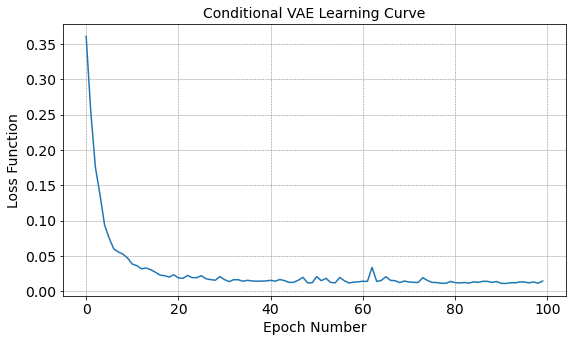

In [29]:
# CVAE learning curve
plt.figure(figsize=(9, 5))
plt.plot(cvae_fitter.loss_history)

plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.title("Conditional VAE Learning Curve", size=14)

plt.xticks(size=14)
plt.yticks(size=14)

plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

Let us generate some fake matrices `X_fake_train` and `X_fake_test` and compare them to real `X_train` and `X_test`

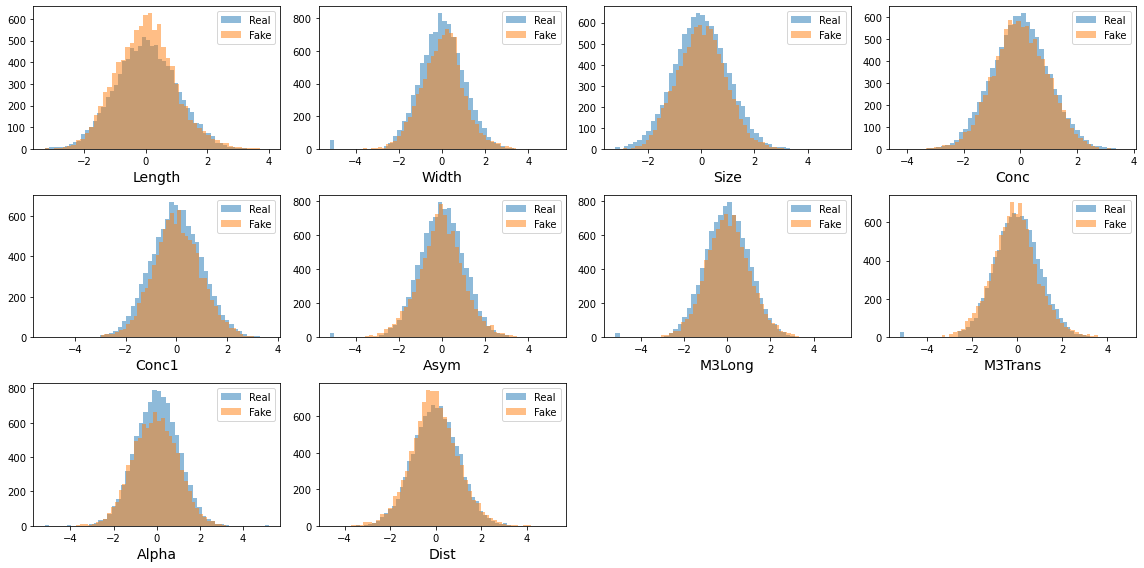

In [30]:
X_fake_train = generate(cvae_fitter.decoder, y_train, latent_dim)
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

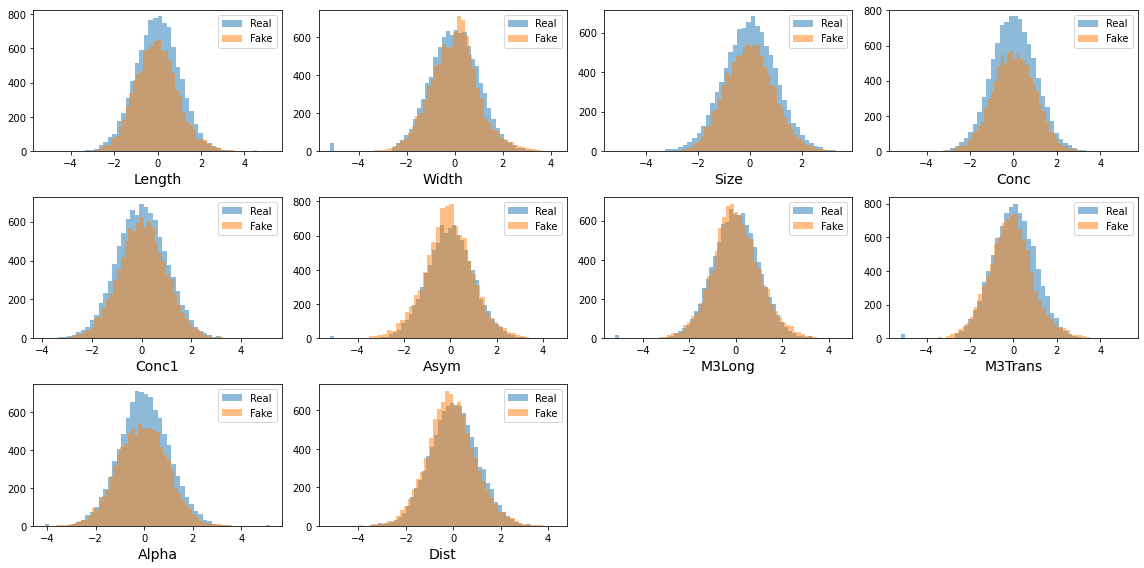

In [31]:
X_fake_test = generate(cvae_fitter.decoder, y_test, latent_dim)
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

Same as before let us use a classificator to tee if it can distinguish fake objects from real ones. We still would like ROC-AUC to be close to 0.5 meaning the classifier cannot set them apart.

In [32]:
# Combine 
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0]*len(X_fake_train) + [1]*len(X_train))
yy_test = np.array([0]*len(X_fake_test) + [1]*len(X_test))

In [33]:
# Train classifier
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# Get results
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [34]:
auc = roc_auc_score(yy_test, yy_test_proba)
print(f'ROC-AUC = {auc}')

ROC-AUC = 0.694827897138548


Same as before ROC-AUC is close enough to the demanded 0.5 yet there is much room for improvement.